In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *

%matplotlib notebook

In [2]:
basepaths = ['/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUNDOWN/Experiment', 
             '/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUNDOWN/N2']
basepaths2 = ['/Users/blandt/Desktop/Data/RING lines/Experiment/211106_nwg325_tom4,15,60',
                '/Users/blandt/Desktop/Data/RING lines/Experiment/211112_nwg325_tom4,15,60',
                '/Users/blandt/Desktop/Data/RING lines/Experiment/211106_nwg338_tom4,15,60',
                '/Users/blandt/Desktop/Data/RING lines/Experiment/211112_nwg338_tom4,15,60']

In [3]:
paths = direcslist(basepaths, 1) + direcslist(basepaths2, 0)
lines = [p.strip('/').split('/')[-2].split('_')[1] for p in paths]
genotype_dict = {'nwg325': 'Wild type', 'n2': 'N2', 'nwg201': 'Wild type, par-3 -/-', 
                 'nwg369': 'L109R, par-3 -/-', 'od58': 'PH', 'nwg338': 'L109R'}
genotypes = [genotype_dict[l] for l in lines]
conditions = [p.strip('/').split('/')[-2].split('_')[2] for p in paths]

imgs_raw = [load_image(glob.glob(p + '/*488 SP 535-50*')[0]) for p in paths]
imgs = [load_image(p + '/af_corrected.tif') for p in paths]
imgs_flat = [load_image(p + '/af_corrected_flat.tif') for p in paths]
imgs_3channel = [load_image(p + '/af_corrected_3channel.tif') for p in paths]
imgs_3channel_flat = [load_image(p + '/af_corrected_3channel_flat.tif') for p in paths]

rois = [np.loadtxt(p + '/ROI_fit.txt') for p in paths]
cytbg = np.loadtxt('../T2A/cytbg.txt')
membg = np.loadtxt('../PAR2 RING MUTANTS/mem_profile.txt')

## Fit1: nonuniform membrane

### Run quantification

In [4]:
iq = ImageQuant(img=imgs, cytbg=cytbg, membg=membg, roi=rois, uni_cyt=False, descent_steps=500, iterations=1, 
                rol_ave=5, lr=0.01)

In [5]:
iq.run()

100%|██████████| 500/500 [07:43<00:00,  1.08it/s]


Time elapsed: 470.53 seconds 


<IPython.core.display.Javascript object>


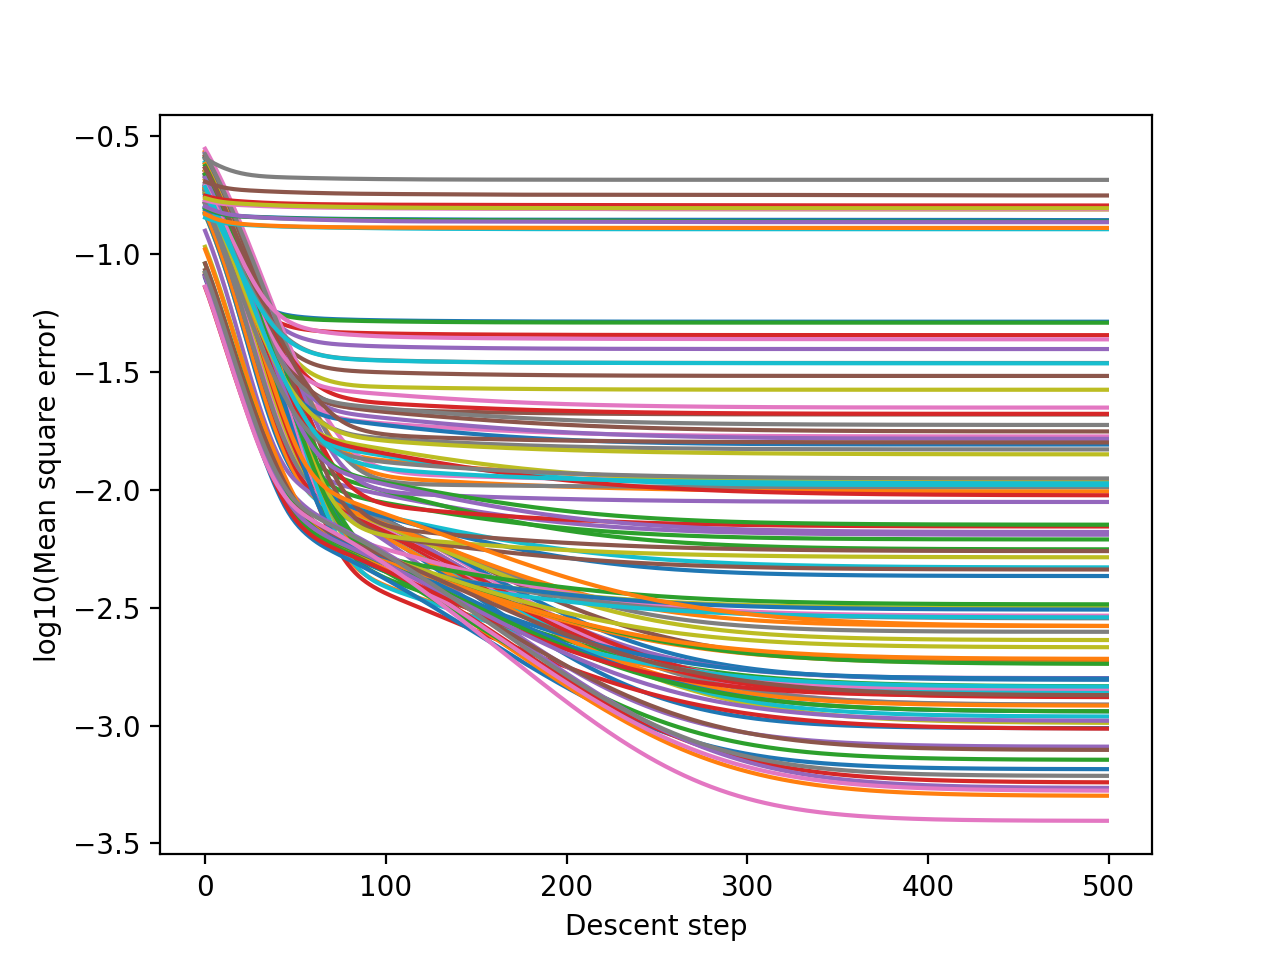

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Descent step', ylabel='log10(Mean square error)'>)

In [6]:
iq.plot_losses(log=True)

<IPython.core.display.Javascript object>


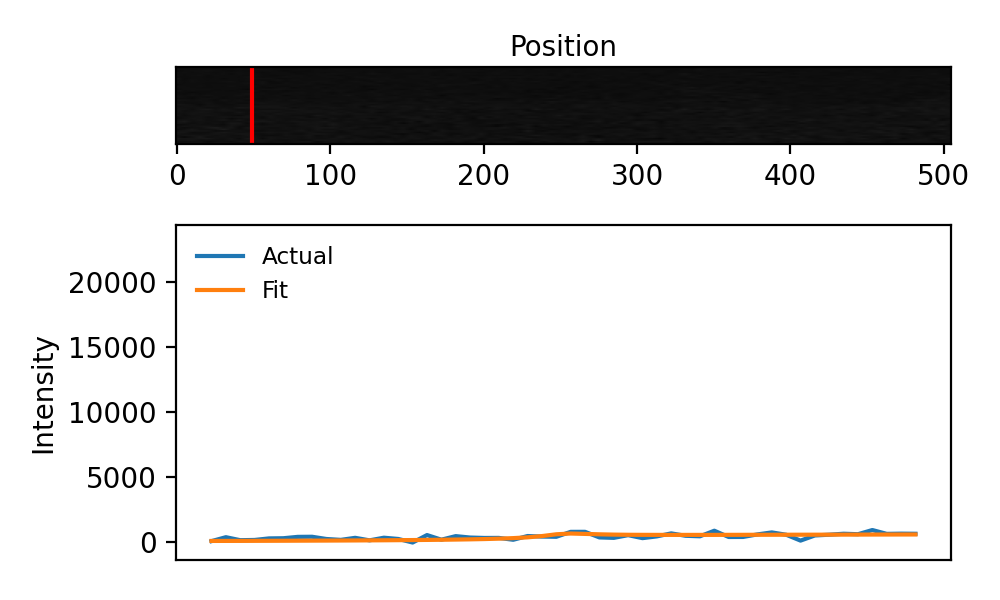

interactive(children=(IntSlider(value=0, description='Frame', max=98), FloatSlider(value=0.1, description='Pos…

(<Figure size 500x300 with 2 Axes>,
 (<AxesSubplot:xlabel='Position'>, <AxesSubplot:ylabel='Intensity'>))

In [7]:
iq.plot_fits(jupyter=True)

In [8]:
# fig, ax = plt.subplots()
# [ax.plot(np.mean(straighten(i, r, 50, ninterp=500), axis=1)) for i, r in zip(iq.img, iq.roi)];

### Compile results

In [9]:
res1 = iq.compile_res()
res1.to_csv('res1.csv')

In [10]:
res1

,Frame,Position,Membrane signal,Cytoplasmic signal
0,0,0,650.051477,341.800032
1,0,1,350.728053,428.407734
2,0,2,153.314435,568.744421
3,0,3,421.656065,562.700150
4,0,4,826.025821,253.349770
...,...,...,...,...
95,98,95,324.718139,-246.770225
96,98,96,162.916973,-32.305045
97,98,97,234.953366,-194.453609
98,98,98,353.558627,-127.322180


In [11]:
res1 = pd.read_csv('res1.csv')
res1_grouped = res1.groupby('Frame')
expand = 5
n2_dosage = np.mean([dosage(i, r, expand) for i, r, c in zip(imgs_raw, rois, lines) if c == 'n2'])
print(n2_dosage)

df = pd.DataFrame()
for i, r in res1_grouped:
    dosage_n2_sub = dosage(imgs_raw[i], rois[i], expand) - n2_dosage
    dosage_af = dosage(imgs[i], rois[i], expand)
    cyt = np.mean(r['Cytoplasmic signal'])
    mem_tot = np.mean(r['Membrane signal'])
    mem_ant = bounded_mean_1d(r['Membrane signal'], [0.4, 0.6])
    mem_post = bounded_mean_1d(r['Membrane signal'], [0.9, 0.1])
    
    p = {'ID': i, 'Line': lines[i], 'Condition': conditions[i], 'Path': paths[i], 'Cyt': cyt, 'Mem_tot': mem_tot, 
         'Mem_ant': mem_ant, 'Mem_post': mem_post, 'Dosage_af': dosage_af, 'Dosage_sub': dosage_n2_sub,
        'Genotype': genotypes[i]} 
    df = df.append(pd.DataFrame(p, index=[i]))
    
df.to_csv('res1_df.csv')
df

4152.721153591059


,ID,Line,Condition,Path,Cyt,Mem_tot,Mem_ant,Mem_post,Dosage_af,Dosage_sub,Genotype
0,0,nwg201,11121830par2rnai,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,382.994670,365.867335,352.351908,462.860207,431.417793,266.590571,"Wild type, par-3 -/-"
1,1,nwg201,11121830par2rnai,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,1058.870064,1774.382216,1534.443560,2463.534942,1369.225169,1885.170369,"Wild type, par-3 -/-"
2,2,nwg201,11121830par2rnai,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,453.833363,294.904203,210.663450,395.079821,477.018692,617.004962,"Wild type, par-3 -/-"
3,3,nwg201,11121830par2rnai,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,490.108746,245.909247,202.167881,326.861332,472.357707,27.534898,"Wild type, par-3 -/-"
4,4,nwg201,11121830par2rnai,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,568.811468,454.158693,287.195538,616.424589,608.173290,643.590486,"Wild type, par-3 -/-"
...,...,...,...,...,...,...,...,...,...,...,...
94,94,n2,11161900par2,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,3.110326,123.917289,211.095473,121.427750,23.166837,-261.828021,N2
95,95,n2,wt,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,-54.687747,-68.921405,-123.860061,36.827394,-73.397414,492.787304,N2
96,96,n2,wt,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,-22.421959,71.582641,-2.775138,136.369636,-23.393533,130.996046,N2
97,97,n2,wt,/Users/blandt/Desktop/Data/Rundowns/PAR-2 RUND...,-80.713361,-181.019817,-173.280786,-165.155880,-134.336944,184.120824,N2


## Fit2: uniform membrane

### Run quantification

In [12]:
# iq2_lines = [c for c in lines if c in ['od58', 'nwg201', 'nwg369', 'n2']]
# iq2_imgs = [i for i, c in zip(imgs, conditions) if c in ['od58', 'nwg201', 'nwg369', 'n2']]
# iq2_rois = [r for r, c in zip(rois, conditions) if c in ['od58', 'nwg201', 'nwg369', 'n2']]

# iq2 = ImageQuant(img=iq2_imgs, cytbg=cytbg, membg=membg, roi=iq2_rois, uni_cyt=True, descent_steps=200, iterations=1, 
#                 rol_ave=5, uni_mem=True, lr=0.02)

In [13]:
# iq2.run()

In [14]:
# iq2.plot_losses()

In [15]:
# iq2.plot_fits(jupyter=True)

### Compile results

In [16]:
# res2 = iq2.compile_res()
# res2.to_csv('res2.csv')

## Fit3: limited to posterior

In [17]:
# rois_post = [np.vstack((r[int(r.shape[0] * 0.9):, :], r[:int(r.shape[0] * 0.1), :])) for r in rois]

In [18]:
# iq3 = ImageQuant(img=imgs, cytbg=cytbg, membg=membg, roi=rois_post, uni_cyt=True, descent_steps=500, 
#                  iterations=1, rol_ave=5, uni_mem=True, lr=0.01, nfits=20, periodic=False)

In [19]:
# iq3.run()

In [20]:
# iq3.plot_fits(jupyter=True)

In [21]:
# res3 = iq3.compile_res()
# res3.to_csv('res3.csv')

In [22]:
# res3 = pd.read_csv('res3.csv')
# res3_grouped = res3.groupby('Frame')
# expand = 5
# n2_dosage = np.mean([dosage(i, r, expand) for i, r, c in zip(imgs_raw, rois, lines) if c == 'n2'])

# df = pd.DataFrame()
# for i, r in res3_grouped:
#     dosage_n2_sub = dosage(imgs_raw[i], rois[i], expand) - n2_dosage
#     dosage_af = dosage(imgs[i], rois[i], expand)
#     cyt = np.mean(r['Cytoplasmic signal'])
#     mem_post = np.mean(r['Membrane signal'])
    
#     p = {'ID': i, 'Line': lines[i], 'Condition': conditions[i], 'Path': paths[i], 'Cyt': cyt, 
#          'Mem_post': mem_post, 'Dosage_af': dosage_af, 'Dosage_sub': dosage_n2_sub, 'Genotype': genotypes[i]} 
#     df = df.append(pd.DataFrame(p, index=[i]))
    
# df.to_csv('res3_df.csv')
# df